In [70]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## TÌM HIỂU CONVOLUTIONAL NEURAL NETWORK - mạng tích chập nhân tạo

In [71]:
import pandas as pd
import numpy as np
import matplotlib as plt
import cv2 as cv2
import tensorflow
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from sklearn.utils import shuffle
import os
from tensorflow.keras.applications import EfficientNetB5
import matplotlib.pyplot as plot
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras import backend as K


In [72]:
dataset_path = '/content/gdrive/My Drive/fer2013/fer2013.csv'
image_size=(48,48)

def load_fer2013():
        data = pd.read_csv(dataset_path)
        # data dạng : 
        # 'emotions' 'pixel'
        #    1     0 10 23  ... 12  
        pixels = data['pixels']
        emos = data['emotion']
        emotions = LabelEncoder().fit_transform(emos)
        width, height = 48, 48 # kích thước bức ảnh
        faces = []
        # emotions = []
        for (pixel_sequence, emotion) in zip(pixels, emos):
            face = [pixel for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height) # resize kích thước 48*48 phòng trường hợp sai kích thước
            faces.append(face)
            # emotions.append(seq_emotion)
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)  # chiều ma trận dữ liệu (35000, 48, 48, 1) 
        emotions = np.array(emotions)
        return faces, emotions




In [73]:
faces, emotions = load_fer2013()

[0 1 2 3 4 5 6] [4953  547 5121 8989 6077 4002 6198]
z:  {'Angry': 4953, 'disgust': 547, 'Fear': 5121, 'Happy': 8989, 'Sad': 6077, 'Surprise': 4002, 'Neutral': 6198}


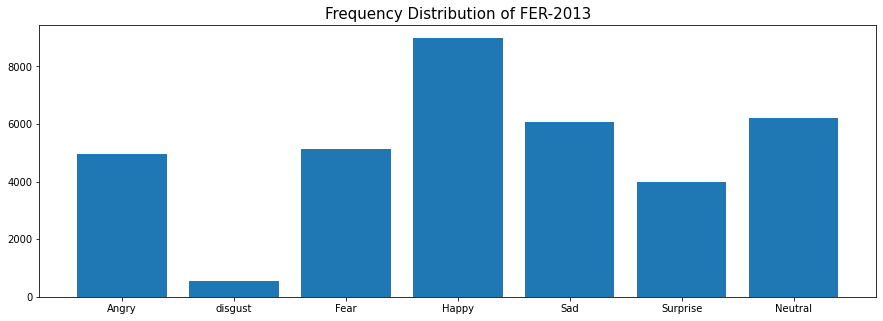

In [74]:
unique, counts = np.unique(emotions, return_counts=True) 
labels =  ["Angry","disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
print(unique, counts)
z={}
for i,k in zip(labels, counts):
  z[i] = k
print("z: ", z)
frequencies = [z[i] for i in z.keys()]


plt.figure(figsize=(15, 5))
plt.bar(labels, frequencies)

plt.title('Frequency Distribution of FER-2013', fontsize=15)

plt.show()

In [75]:
faces.shape, emotions.shape

((35887, 48, 48, 1), (35887,))

In [76]:

from sklearn.model_selection  import train_test_split
trainX, testX,trainY,testY = train_test_split(faces, emotions,test_size=0.2, random_state=42, shuffle=True)

# sinh dữ liệu để model học nhiều hơn
aug = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
batch_size = 64

train_flow = aug.flow(trainX,trainY, batch_size=batch_size) 
test_flow = aug.flow(testX, testY, batch_size=batch_size) 

print("xtrain shape: ",trainX.shape)
print("ytrain shape: ",trainY.shape)
print("test shape: ",testX.shape)
print("test shape: ",testY.shape)

xtrain shape:  (28709, 48, 48, 1)
ytrain shape:  (28709,)
test shape:  (7178, 48, 48, 1)
test shape:  (7178,)


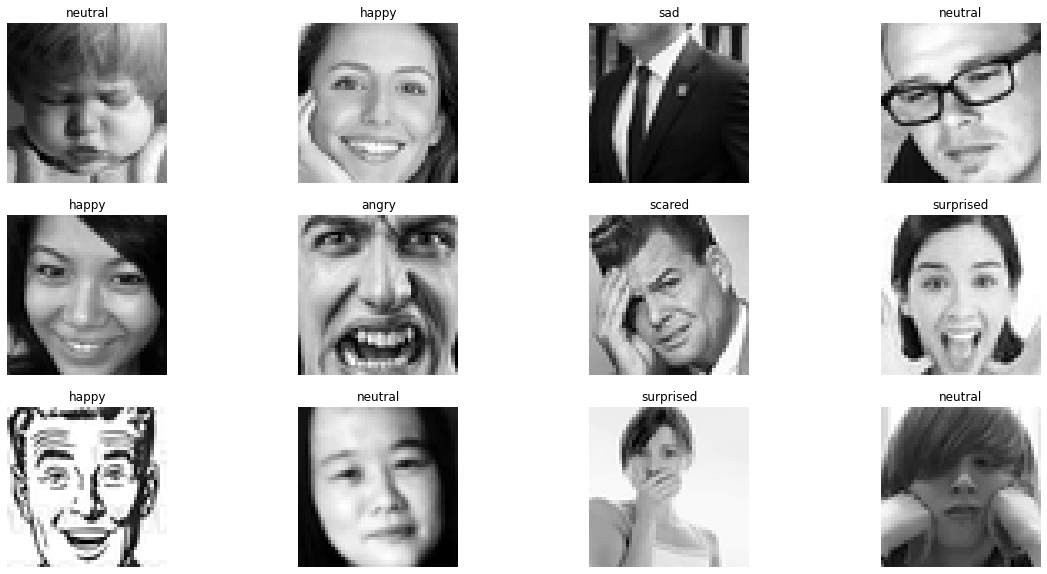

In [77]:
import seaborn as sns
EMOTIONS = ["angry" ,"disgust", "scared", "happy", "sad", "surprised",
 "neutral"]
plt.figure(0, figsize=(20,10))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.axis('off')
    plt.imshow(trainX[i, :, :, 0].astype('float'), cmap="gray")
    plt.title(EMOTIONS[trainY[i]])
  


plt.show()

In [78]:
from tensorflow.keras import layers,initializers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, SGD



# VGG-16 của imagenet 
# nhưng chỉ lấy khung, không lấy weights - trọng số
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7

    def bias_initializer():
      return initializers.Constant(0.1)

    def kernel_initializer():
      return initializers.TruncatedNormal(mean=0., stddev=0.1)

    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='swish', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='swish', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='swish', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='swish', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='swish', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='swish', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='swish', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='swish', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='swish', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='swish', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    x = layers.Dense(512, activation='swish', name='fc3')(flatten)
    x = layers.Dense(256, activation='swish', name='fc4')(x)
    x = layers.Dropout(0.45, name='drop_5')(x)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(x)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model
    

In [79]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_17 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)        0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [80]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.6, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

num_epochs = 300 # we iterate 200 times over the entire training set 
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(trainX) / batch_size, 
                    epochs=70,  
                    verbose=1,  
                    callbacks=reduce_lr,
                    validation_data=test_flow,  
                    validation_steps=len(testX) / batch_size) 




Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


448/448 [==============================] - 44s 92ms/step - loss: 1.8399 - accuracy: 0.2425 - val_loss: 2.0977 - val_accuracy: 0.2459
Epoch 2/70
448/448 [==============================] - 40s 90ms/step - loss: 1.6994 - accuracy: 0.3147 - val_loss: 1.5973 - val_accuracy: 0.3838
Epoch 3/70
448/448 [==============================] - 40s 90ms/step - loss: 1.5653 - accuracy: 0.3865 - val_loss: 1.5640 - val_accuracy: 0.4189
Epoch 4/70
448/448 [==============================] - 40s 90ms/step - loss: 1.4652 - accuracy: 0.4355 - val_loss: 1.4201 - val_accuracy: 0.4710
Epoch 5/70
448/448 [==============================] - 40s 90ms/step - loss: 1.3804 - accuracy: 0.4733 - val_loss: 1.3026 - val_accuracy: 0.5026
Epoch 6/70
448/448 [==============================] - 40s 89ms/step - loss: 1.3090 - accuracy: 0.5005 - val_loss: 1.3436 - val_accuracy: 0.5021
Epoch 7/70
448/448 [==============================] - 40s 90ms/step - loss: 1.2546 - accuracy: 0.5229 - val_loss: 1.2598 - val_accuracy: 0.5261
Epo

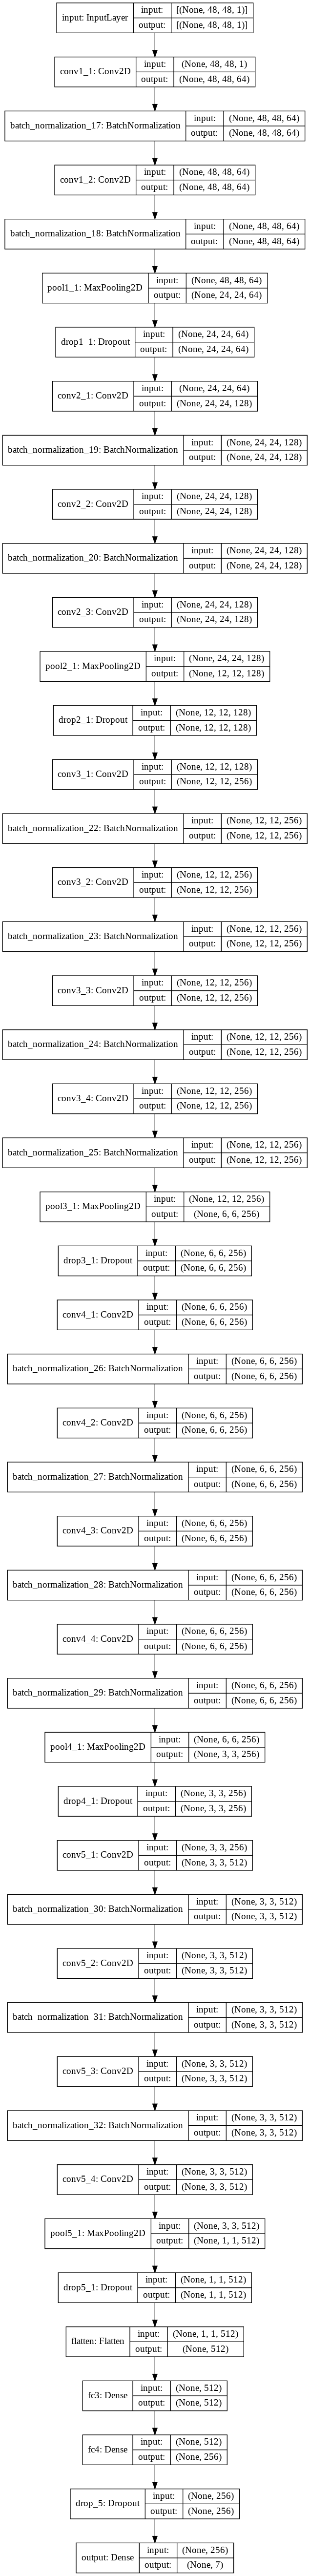

In [81]:
dot_img_file = '/content/gdrive/MyDrive/fer2013/model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [84]:
testX = testX.astype('float32')/255.0
result = model.evaluate(testX, testY) 
print("Test Loss " + str(result[0]))
print("Test Acc: " + str(result[1]))

225/225 [==============================] - 4s 16ms/step - loss: 1.1540 - accuracy: 0.6924
Test Loss 1.1540462970733643
Test Acc: 0.69239342212677


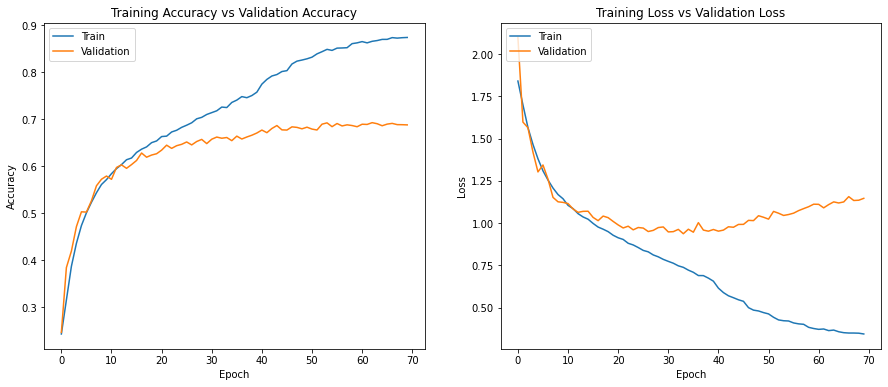

In [85]:

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(15,6)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

In [86]:
from tensorflow import keras

target_names =  ["Angry","disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
target_names_reverse = ["Neutral", "Surprise", "Sad", "Happy", "Fear", "Disgust", "Angry"]
print("[INFO] evaluating network...")


predictions = model.predict(testX, batch_size=64)





[INFO] evaluating network...


              precision    recall  f1-score   support

       Angry       0.61      0.60      0.60       985
     disgust       0.76      0.72      0.74       102
        Fear       0.64      0.51      0.57      1043
       Happy       0.87      0.87      0.87      1765
         Sad       0.57      0.62      0.59      1210
    Surprise       0.75      0.79      0.77       795
     Neutral       0.64      0.68      0.66      1278

    accuracy                           0.69      7178
   macro avg       0.69      0.68      0.68      7178
weighted avg       0.69      0.69      0.69      7178



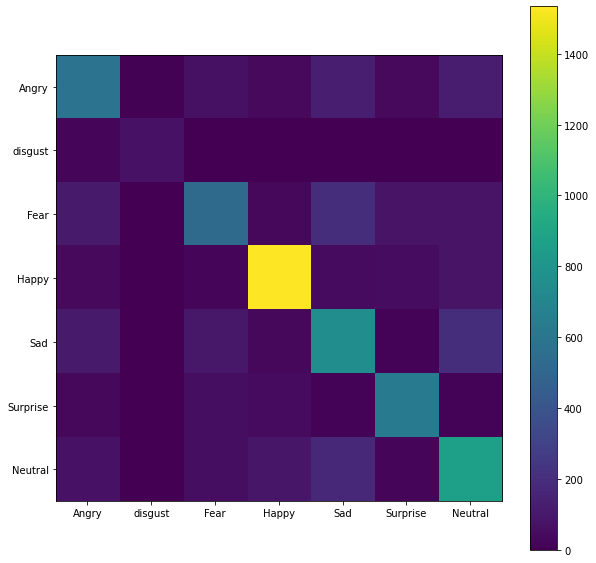

In [87]:
print(classification_report(testY, predictions.argmax(axis=1), target_names=labelNames))
from sklearn import metrics

import scikitplot, matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

cm_train = metrics.confusion_matrix(testY, predictions.argmax(axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cm_train)
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=0)
_ = plt.yticks(tick_mark, target_names)
matplotlib.pyplot.savefig("/content/gdrive/MyDrive/results/confusion_matrix.png")

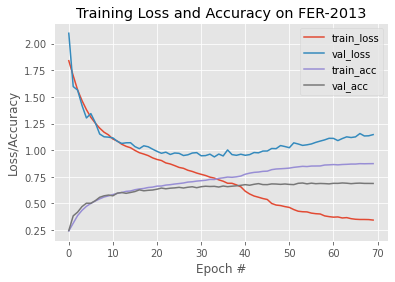

In [89]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 70), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 70), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 70), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 70), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on FER-2013")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()